In [1]:
# basic packages:
import pandas as pd
import numpy as np

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import set_matplotlib_formats
import seaborn as sns
import networkx as nx

# stats
from scipy import stats
import pingouin as pg
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter('ignore')

In [2]:
# importing custom functions from this repository
from individual_differences_helper_functions import *

### These analyses are based on the code provided by Cooper and Ritchey (2022), which can be found here: https://github.com/memobc/paper-vividness-features
### They have been extended to allow for an additional manipulation of an age group (both young and older adults have been tested) and an additional dependent variable - a confidence rating


In [3]:
df = pd.read_csv('.\data\data_cleaned.csv')
df.head()

,Unnamed: 0,participant,event_id,encoding.thisN,theme,object_label,person_label,place_label,resp_encSpace.rt,retrieval.thisN,...,sun_4,shop_1,shop_2,shop_3,shop_4,scene_1,scene_2,scene_3,scene_4,age
0,0,100,17,1,Summer,Puppy,Sandra,Circus,15.0042,9,...,5,5,3,4,2,5,4,5,4,0
1,1,100,11,2,Games,Binoculars,Harrison,Lake,12.2719,6,...,5,5,3,4,2,5,4,5,4,0
2,2,100,18,3,DIY,Chair,Beyonce,Winecellar,18.8351,15,...,5,5,3,4,2,5,4,5,4,0
3,3,100,4,4,Exercise,Beachball,Will,Casino,10.3913,23,...,5,5,3,4,2,5,4,5,4,0
4,4,100,10,5,Work,Easel,Sean,Aquarium,16.0599,18,...,5,5,3,4,2,5,4,5,4,0


In [4]:
ntrials = df.groupby('participant').count()
if any(ntrials["event_id"] != 24):
    print('Error: at least one subject does not have 24 trials')
else:
    print('All subjects have 24 trials')

All subjects have 24 trials


In [5]:
print('Nr of participants: ',len(df['participant'].unique()))

Nr of participants:  193


# Data formatting

In [6]:
memory_data = create_memory_data(df)
memory_data.head()

,participant,age,event,vividness,confidence,detail_object,detail_person,detail_place,gist_object,gist_person,gist_place
0,100,0,17,1.703704,2.300926,1,1,0,0,0,1
1,100,0,11,5.805556,5.805556,0,1,1,1,1,1
2,100,0,18,5.888889,5.888889,1,1,0,1,1,1
3,100,0,4,2.462963,3.648148,1,0,1,1,1,1
4,100,0,10,5.370371,4.462963,1,0,1,1,1,1


# Descriptives

In [7]:
# summarise across all trials (events) per subject
memory_summary = memory_data.groupby(['participant','age']).mean().drop('event',axis=1).reset_index()
memory_temp = memory_summary.copy()
# print average performance for each experiment group:
memory_summary.groupby('age').describe().drop(columns='participant').loc[:, (slice(None), ['mean','std'])]

vividness           confidence           detail_object            \
         mean       std       mean       std          mean       std   
age                                                                    
0    3.282665  0.906765   3.754311  0.937892      0.732205  0.128496   
1    2.475960  0.936901   2.679033  1.050706      0.707045  0.144269   

    detail_person           detail_place           gist_object            \
             mean       std         mean       std        mean       std   
age                                                                        
0        0.733073  0.117786     0.712674  0.138718    0.802083  0.180662   
1        0.693299  0.133016     0.666237  0.144149    0.690722  0.173975   

    gist_person           gist_place            
           mean       std       mean       std  
age                                             
0      0.718316  0.202393   0.791233  0.195761  
1      0.667955  0.199233   0.680412  0.196332

In [8]:
memory_summary.head()

,participant,age,vividness,confidence,detail_object,detail_person,detail_place,gist_object,gist_person,gist_place
0,1,1,3.580440,4.120563,0.666667,0.708333,0.750000,0.833333,0.791667,0.708333
1,2,1,1.502701,1.511381,0.666667,0.708333,0.583333,0.625000,0.416667,0.458333
2,3,1,3.670898,3.706977,0.833333,0.750000,0.958333,0.625000,0.708333,0.750000
3,4,1,1.995285,1.932041,0.791667,0.500000,0.666667,0.708333,0.416667,0.750000
4,5,1,1.960455,1.768133,0.666667,0.541667,0.625000,0.541667,0.291667,0.416667


In [9]:
#get float (memory measure) columns:
float_cols = ['vividness', 'confidence', 'gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person', 'detail_place']

In [10]:
# Standardising both age groups separately - no direct comparisons will be conducted
older_df, younger_df = [x for _, x in memory_temp.groupby(memory_temp['age'] == 0)]
scaler = StandardScaler()
older_df[float_cols] = scaler.fit_transform(older_df[float_cols])
scaler = StandardScaler()
younger_df[float_cols] = scaler.fit_transform(younger_df[float_cols])
memory_norm = pd.concat([older_df, younger_df])

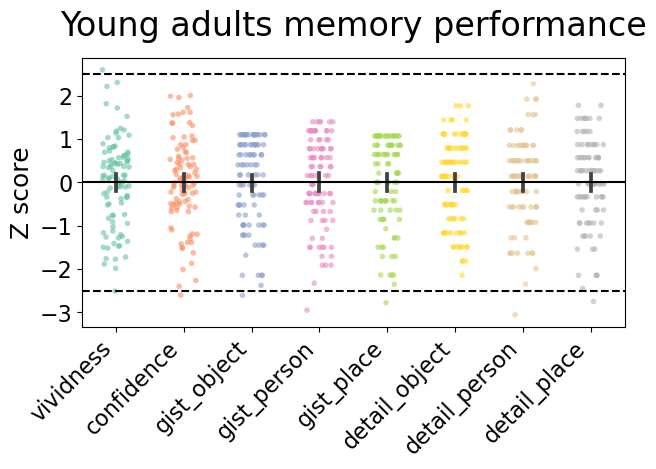

In [11]:
plot_data = younger_df.melt(value_vars=float_cols, var_name='Measure',
                             value_name='Z', id_vars=['participant'])

plt.figure(figsize=(7,3.5))
sns.barplot(data=plot_data, x='Measure', y='Z',
           palette="Set2", alpha=.8)
g = sns.stripplot(data=plot_data, x='Measure', y='Z',
              palette="Set2", jitter=.2,
              dodge=True, size=4, zorder=0, alpha=.6)
plt.xlabel("")
plt.xticks(fontsize=16, rotation=45, ha="right")
plt.ylabel("Z score", fontsize=18)
plt.yticks(fontsize=16)
plt.title('Young adults memory performance', fontsize=24, y=1.05)
plt.axhline(0,ls="-",color="black")  #chance
plt.axhline(-2.5,ls="--",color="black")  #outlier
plt.axhline(2.5,ls="--",color="black")  #outlier
plt.savefig("./plots/younger_inddiff_outlier_check.png", bbox_inches = 'tight')

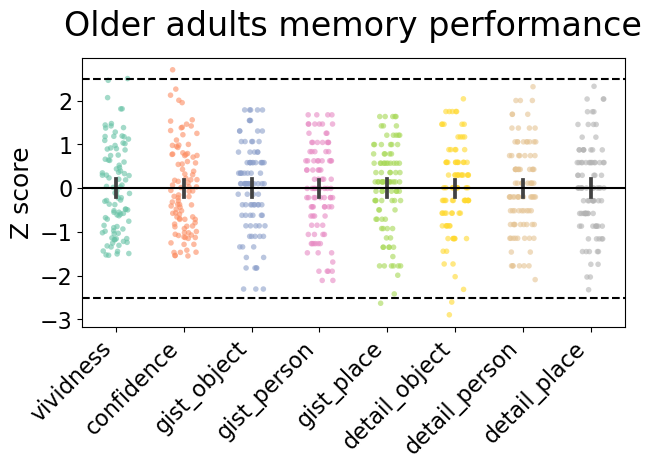

In [12]:
plot_data = older_df.melt(value_vars=float_cols, var_name='Measure',
                             value_name='Z', id_vars=['participant'])

plt.figure(figsize=(7,3.5))
sns.barplot(data=plot_data, x='Measure', y='Z',
           palette="Set2", alpha=.8)
g = sns.stripplot(data=plot_data, x='Measure', y='Z',
              palette="Set2", jitter=.2,
              dodge=True, size=4, zorder=0, alpha=.6)
plt.xlabel("")
plt.xticks(fontsize=16, rotation=45, ha="right")
plt.ylabel("Z score", fontsize=18)
plt.yticks(fontsize=16)
plt.title('Older adults memory performance', fontsize=24, y=1.05)
plt.axhline(0,ls="-",color="black")  #chance
plt.axhline(-2.5,ls="--",color="black")  #outlier
plt.axhline(2.5,ls="--",color="black")  #outlier
plt.savefig("./plots/older_inddiff_outlier_check.png", bbox_inches = 'tight')

## Vividness correlations

In [13]:
# calculate gist-specific correlations
cor_params_gist = rating_correlations(memory_data, ["gist_object","gist_person","gist_place"], "vividness")

In [14]:
# calculate detail-specific correlations (where gist = 1)
cor_detail_object = rating_correlations(memory_data[memory_data.gist_object == 1], ["detail_object"], "vividness")
cor_detail_person = rating_correlations(memory_data[memory_data.gist_person == 1], ["detail_person"], "vividness")
cor_detail_place = rating_correlations(memory_data[memory_data.gist_place == 1], ["detail_place"], "vividness")

# merge detail to single df:
cor_params_detail = cor_detail_object.merge(cor_detail_person, how="outer")
cor_params_detail = cor_params_detail.merge(cor_detail_place, how="outer")

In [15]:
cor_params_vividness = cor_params_gist.merge(cor_params_detail, how="outer").rename(columns={'index': 'participant'})

In [16]:
cor_params_vividness.head()

,participant,age,gist_object,gist_person,gist_place,detail_object,detail_person,detail_place
0,100,0,0.479651,0.582086,0.327035,-0.145526,0.141171,-0.11277
1,101,0,0.384678,0.062181,0.308122,0.382971,-0.31053,0.422577
2,102,0,0.0,0.03053,0.346485,0.19605,0.196116,-0.040301
3,103,0,-0.19584,-0.373194,0.244609,-0.24216,0.0,0.18795
4,104,0,0.180775,0.218092,0.225969,0.328564,0.260133,-0.302482


In [58]:
cor_params_vividness.to_csv('./data/cor_params_vividness.csv', index=False)

# Confidence correlations

In [18]:
float_cols = ['confidence', 'gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person', 'detail_place']

In [19]:
# calculate gist-specific correlations
cor_params_gist = rating_correlations(memory_data, ["gist_object","gist_person","gist_place"], "confidence")

In [20]:
# calculate detail-specific correlations (where gist = 1)
cor_detail_object = rating_correlations(memory_data[memory_data.gist_object == 1], ["detail_object"], "confidence")
cor_detail_person = rating_correlations(memory_data[memory_data.gist_person == 1], ["detail_person"], "confidence")
cor_detail_place = rating_correlations(memory_data[memory_data.gist_place == 1], ["detail_place"], "confidence")

# merge detail to single df:
cor_params_detail = cor_detail_object.merge(cor_detail_person, how="outer")
cor_params_detail = cor_params_detail.merge(cor_detail_place, how="outer")

In [21]:
cor_params_confidence = cor_params_gist.merge(cor_params_detail, how="outer").rename(columns={'index': 'participant'})
#cor_params_confidence = cor_params_confidence[~cor_params_confidence.participant.isin(excluded_sub)]
cor_params_confidence.shape

(193, 8)

In [59]:
cor_params_confidence.to_csv('./data/cor_params_confidence.csv', index=False)

# Memory Attribute Correlations

In [23]:
float_cols = ['vividness','confidence', 'gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person', 'detail_place']

## Older

In [24]:
# correlate
memory_cors_norm_older = older_df[float_cols].corr(method='spearman')   
np.fill_diagonal(memory_cors_norm_older.values, np.nan)

# and define which correlations are significant based on critical r:
pmask, labels, r_sig = fetch_sig_cors(memory_cors_norm_older, older_df.shape[0])
print('bonferroni-corrected critical r =',np.round(r_sig,3))

bonferroni-corrected critical r = 0.293


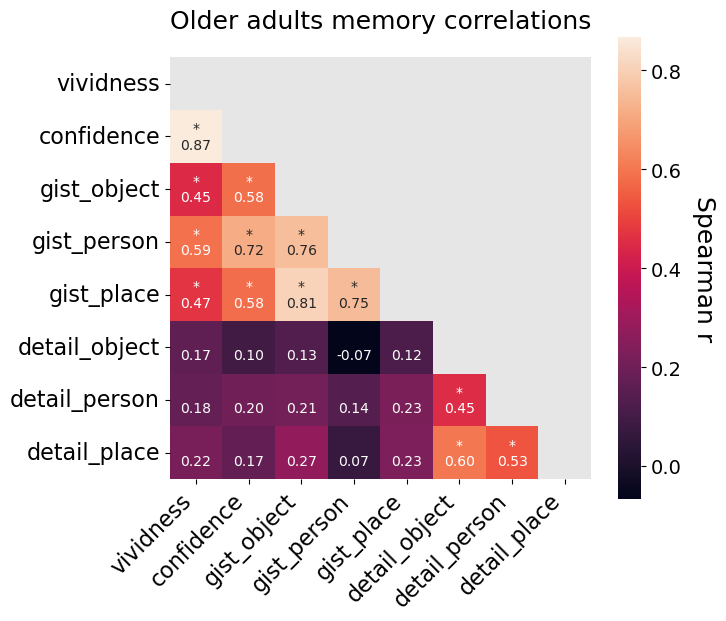

<Figure size 640x480 with 0 Axes>

In [25]:
plot_cor_heatmap(memory_cors_norm_older, l = labels, cmap="rocket", title = 'Older adults memory correlations')
plt.show()
plt.savefig("./plots/older_inddiff_heatmap_performance.png", bbox_inches = 'tight')

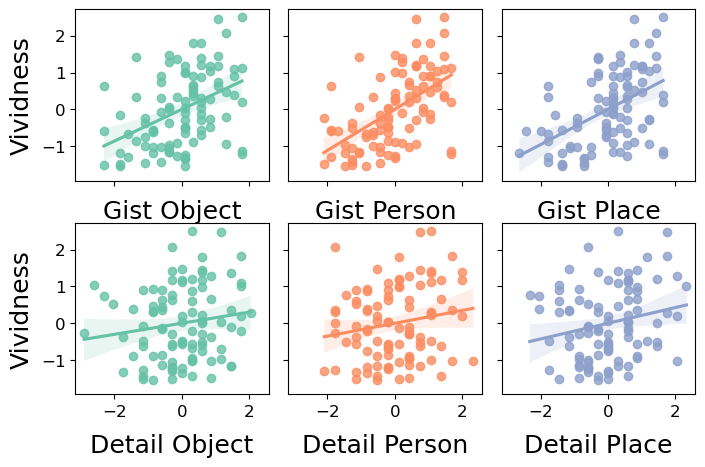

In [26]:
# get colors:
this_cmap = cm.get_cmap("Set2", 8) 
this_hex = []
for i in range(this_cmap.N):
    rgb = this_cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    this_hex.append(mpl.colors.rgb2hex(rgb))

# plot:
fig, axes = plt.subplots(2, 3, figsize=(8,5), 
                         sharex=True, sharey=True,
                         gridspec_kw={
                               'wspace': 0.1,
                               'hspace': 0.25})

features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person', 'detail_place']
n=-1
for a in range(2):
    for b in range(3):
        n=n+1
        sns.regplot(ax=axes[a, b],
                    data=older_df[['vividness'] + [features[n]]],
                    x = features[n], y = 'vividness',
                    color=this_hex[b])
        plt.axes(axes[a,b])
        xlab = features[n].split('_')
        plt.xlabel(xlab[0].capitalize() + ' ' + xlab[1].capitalize(), 
                   fontsize=18, labelpad = 10)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        if b == 0:
            plt.ylabel('Vividness', fontsize=18, labelpad = 5)
        else:
            plt.ylabel('')
            
# save 
plt.savefig("plots/older_indiff_across_subject_scatter.pdf", bbox_inches = 'tight')
plt.show()

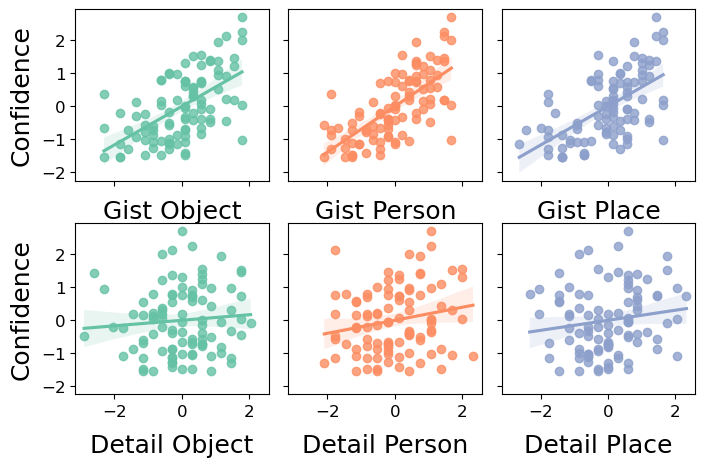

In [27]:
# get colors:
this_cmap = cm.get_cmap("Set2", 8) 
this_hex = []
for i in range(this_cmap.N):
    rgb = this_cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    this_hex.append(mpl.colors.rgb2hex(rgb))

# plot:
fig, axes = plt.subplots(2, 3, figsize=(8,5), 
                         sharex=True, sharey=True,
                         gridspec_kw={
                               'wspace': 0.1,
                               'hspace': 0.25})

features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person', 'detail_place']
n=-1
for a in range(2):
    for b in range(3):
        n=n+1
        sns.regplot(ax=axes[a, b],
                    data=older_df[['confidence'] + [features[n]]],
                    x = features[n], y = 'confidence',
                    color=this_hex[b])
        plt.axes(axes[a,b])
        xlab = features[n].split('_')
        plt.xlabel(xlab[0].capitalize() + ' ' + xlab[1].capitalize(), 
                   fontsize=18, labelpad = 10)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        if b == 0:
            plt.ylabel('Confidence', fontsize=18, labelpad = 5)
        else:
            plt.ylabel('')
            
# save 
plt.savefig("plots/older_conf_indiff_across_subject_scatter.pdf", bbox_inches = 'tight')
plt.show()

## Younger

In [28]:
# correlate
memory_cors_norm_younger = younger_df[float_cols].corr(method='spearman')   
np.fill_diagonal(memory_cors_norm_younger.values, np.nan)

# and define which correlations are significant based on critical r:
pmask, labels, r_sig = fetch_sig_cors(memory_cors_norm_younger, younger_df.shape[0])
print('bonferroni-corrected critical r =',np.round(r_sig,3))

bonferroni-corrected critical r = 0.295


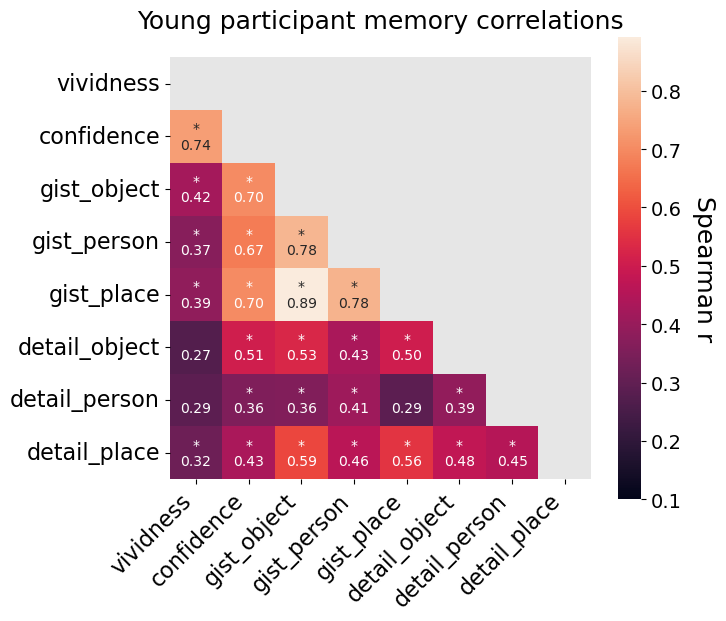

<Figure size 640x480 with 0 Axes>

In [29]:
plot_cor_heatmap(memory_cors_norm_younger, l = labels, cmap="rocket", title = 'Young participant memory correlations')
plt.show()
plt.savefig("./plots/younger_inddiff_heatmap_performance.png", bbox_inches = 'tight')

The pairwise scatter plots showing relationships between attributes and vividness:

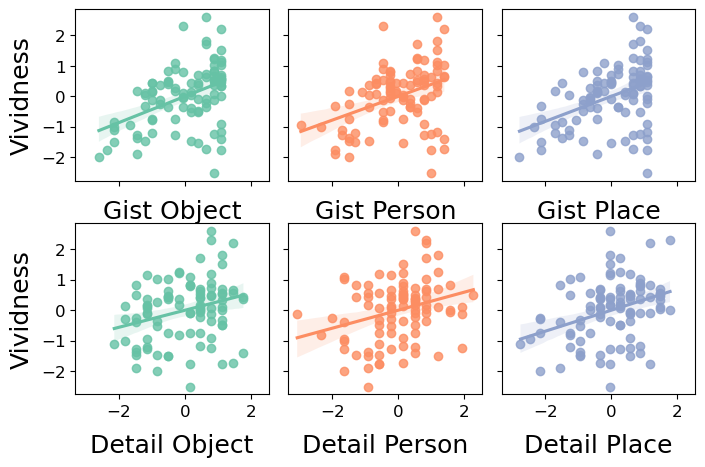

In [30]:
# get colors:
this_cmap = cm.get_cmap("Set2", 8) 
this_hex = []
for i in range(this_cmap.N):
    rgb = this_cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    this_hex.append(mpl.colors.rgb2hex(rgb))

# plot:
fig, axes = plt.subplots(2, 3, figsize=(8,5), 
                         sharex=True, sharey=True,
                         gridspec_kw={
                               'wspace': 0.1,
                               'hspace': 0.25})

features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person', 'detail_place']
n=-1
for a in range(2):
    for b in range(3):
        n=n+1
        sns.regplot(ax=axes[a, b],
                    data=younger_df[['vividness'] + [features[n]]],
                    x = features[n], y = 'vividness',
                    color=this_hex[b])
        plt.axes(axes[a,b])
        xlab = features[n].split('_')
        plt.xlabel(xlab[0].capitalize() + ' ' + xlab[1].capitalize(), 
                   fontsize=18, labelpad = 10)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        if b == 0:
            plt.ylabel('Vividness', fontsize=18, labelpad = 5)
        else:
            plt.ylabel('')
            
# save 
plt.savefig("./plots/younger_indiff_across_subject_scatter.pdf", bbox_inches = 'tight')
plt.show()

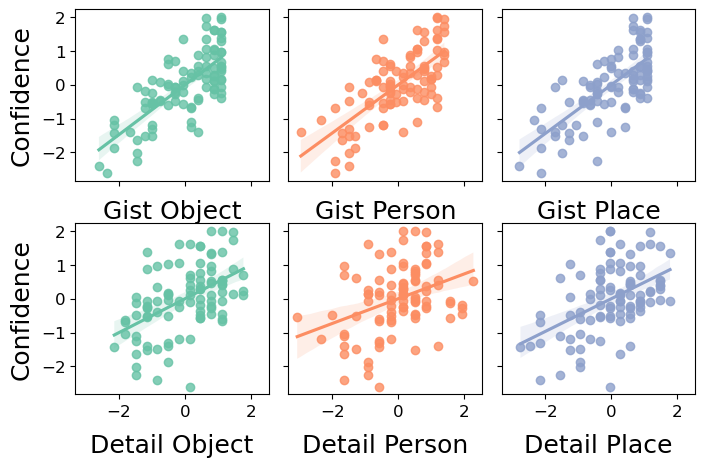

In [31]:
# get colors:
this_cmap = cm.get_cmap("Set2", 8) 
this_hex = []
for i in range(this_cmap.N):
    rgb = this_cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    this_hex.append(mpl.colors.rgb2hex(rgb))

# plot:
fig, axes = plt.subplots(2, 3, figsize=(8,5), 
                         sharex=True, sharey=True,
                         gridspec_kw={
                               'wspace': 0.1,
                               'hspace': 0.25})

features = ['gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person', 'detail_place']
n=-1
for a in range(2):
    for b in range(3):
        n=n+1
        sns.regplot(ax=axes[a, b],
                    data=younger_df[['confidence'] + [features[n]]],
                    x = features[n], y = 'confidence',
                    color=this_hex[b])
        plt.axes(axes[a,b])
        xlab = features[n].split('_')
        plt.xlabel(xlab[0].capitalize() + ' ' + xlab[1].capitalize(), 
                   fontsize=18, labelpad = 10)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        if b == 0:
            plt.ylabel('Confidence', fontsize=18, labelpad = 5)
        else:
            plt.ylabel('')
            
# save 
plt.savefig("./plots/younger_conf_indiff_across_subject_scatter.pdf", bbox_inches = 'tight')
plt.show()

# Questionnaires

In [32]:
ques = pd.read_csv('./data/ques_data.csv')
ques.participant = ques.participant.astype('string')

In [33]:
reverse_cols = ["ep1","ep2","sem2","sem5","spa3","spa4","fut6"]
ques[reverse_cols] = 6 - ques[reverse_cols]


In [34]:
ques[reverse_cols].head()

,ep1,ep2,sem2,sem5,spa3,spa4,fut6
0,2,4,2,4,1,4,4
1,3,3,3,3,3,3,3
2,4,5,4,3,3,5,3
3,4,4,4,4,4,5,4
4,5,4,2,3,1,5,3


In [35]:
cols = [i for i in ques.columns if "ep" in i] 
ques['SAM_episodic'] = ques[cols].mean(axis=1)

cols = [i for i in ques.columns if "sem" in i] 
ques['SAM_semantic'] = ques[cols].mean(axis=1)

cols = [i for i in ques.columns if "spa" in i] 
ques['SAM_spatial'] = ques[cols].mean(axis=1)

cols = [i for i in ques.columns if "fut" in i] 
ques['SAM_future'] = ques[cols].mean(axis=1)

cols = [i for i in ques.columns if any(p in i for p in ["per_","sun_","shop_","scene_"])]
ques['Visual_imagery'] = ques[cols].mean(axis=1)

In [36]:
ques_all = ques.copy()
ques.shape

(200, 50)

In [37]:
# merge with (filtered) memory data
memory_norm.participant = memory_norm.participant.astype('string')
ques = ques.merge(memory_norm, on=['participant', 'age'])
ques.shape

(193, 58)

In [38]:
older_ques_df, younger_ques_df = [x for _, x in ques.groupby(ques['age'] == 0)]

In [39]:
pg.normality(data=ques, dv='SAM_episodic', group='age')

,W,pval,normal
age,,,
0,0.975623,0.070393,True
1,0.990979,0.760722,True


In [40]:
pg.ttest(older_ques_df.SAM_episodic, younger_ques_df.SAM_episodic)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.426307,189.243307,two-sided,0.670369,"[-0.27, 0.17]",0.061401,0.17,0.070873


In [41]:
pg.normality(data=ques, dv='SAM_semantic', group='age')

,W,pval,normal
age,,,
0,0.982887,0.245165,True
1,0.991925,0.829964,True


In [42]:
pg.ttest(older_ques_df.SAM_semantic, younger_ques_df.SAM_semantic)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.164433,190.976005,two-sided,0.245701,"[-0.33, 0.09]",0.167638,0.294,0.212366


In [43]:
pg.normality(data=ques, dv='SAM_spatial', group='age')

,W,pval,normal
age,,,
0,0.962587,0.007738,False
1,0.945619,0.000538,False


In [44]:
pg.mwu(older_ques_df.SAM_spatial, younger_ques_df.SAM_spatial)

,U-val,alternative,p-val,RBC,CLES
MWU,6014.0,two-sided,0.000454,-0.291667,0.645833


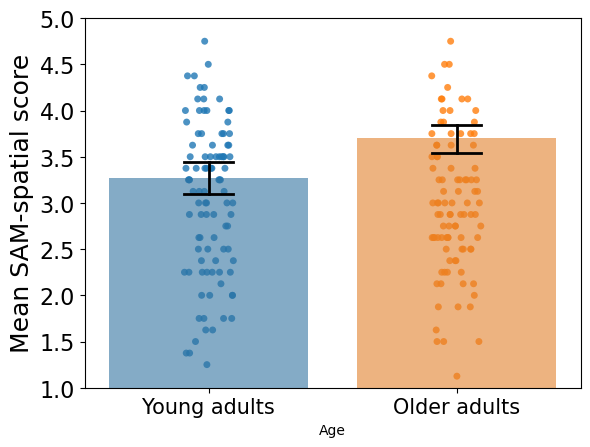

In [45]:
sns.barplot(y='SAM_spatial', x='age',
            data=ques,
            alpha=.6, dodge=True, errcolor="k",
            errwidth=2, capsize=.2)
sns.stripplot(y='SAM_episodic', x='age',
              data=ques,
              size=5, alpha=.8, zorder=0, jitter=.1)
plt.ylabel('Mean SAM-spatial score', fontsize=18)
plt.xlabel('Age')
plt.yticks(fontsize=16)
plt.xticks(np.arange(2), ['Young adults', 'Older adults'], fontsize=15)
plt.grid(False)
plt.ylim(1,5)
plt.savefig("./plots/SAM_spatial_barplot.pdf", bbox_inches = 'tight')
plt.show()

In [46]:
pg.normality(data=ques, dv='SAM_future', group='age')

,W,pval,normal
age,,,
0,0.952629,0.001623,False
1,0.974293,0.053647,True


In [47]:
pg.mwu(older_ques_df.SAM_future, younger_ques_df.SAM_future)

,U-val,alternative,p-val,RBC,CLES
MWU,4211.0,two-sided,0.250892,0.095576,0.452212


In [48]:
pg.normality(data=ques, dv='Visual_imagery', group='age')

,W,pval,normal
age,,,
0,0.979278,0.132780,True
1,0.968348,0.019169,False


In [49]:
pg.mwu(older_ques_df.Visual_imagery, younger_ques_df.Visual_imagery)

,U-val,alternative,p-val,RBC,CLES
MWU,5341.0,two-sided,0.07755,-0.147122,0.573561


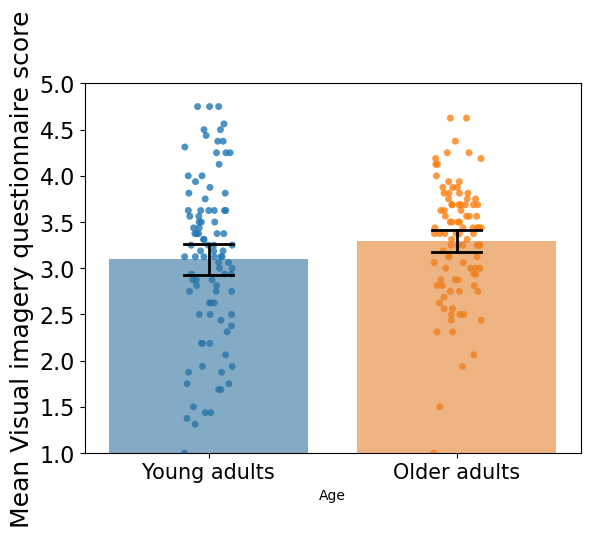

In [50]:
sns.barplot(y='Visual_imagery', x='age',
            data=ques,
            alpha=.6, dodge=True, errcolor="k",
            errwidth=2, capsize=.2)
sns.stripplot(y='Visual_imagery', x='age',
              data=ques,
              size=5, alpha=.8, zorder=0, jitter=.1)
plt.ylabel('Mean Visual imagery questionnaire score', fontsize=18)
plt.xlabel('Age')
plt.yticks(fontsize=16)
plt.xticks(np.arange(2), ['Young adults', 'Older adults'], fontsize=15)
plt.grid(False)
plt.ylim(1,5)
plt.savefig("./plots/VVIQ_barplot.pdf", bbox_inches = 'tight')
plt.show()

In [51]:
ques_measures = ['SAM_episodic', 'SAM_semantic', 'SAM_spatial', 'SAM_future', 'Visual_imagery']
measures = ['SAM_episodic','Visual_imagery', 'vividness',
 'confidence',
 'gist_object',
 'gist_person',
 'gist_place',
 'detail_object',
 'detail_person',
 'detail_place',
 ]

## Older

bonferroni-corrected critical r = 0.185


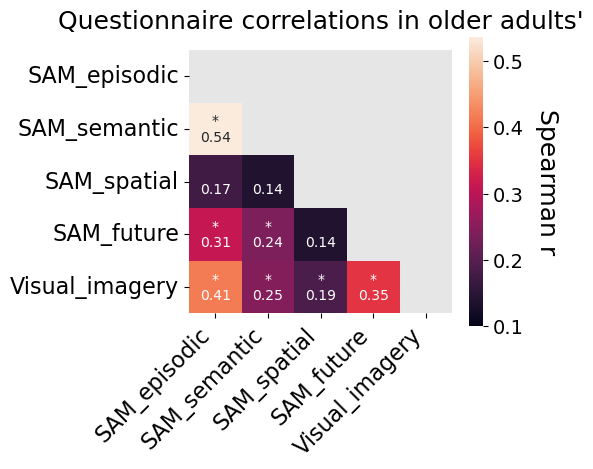

In [52]:
ques_data_older = older_ques_df[ques_measures]
ques_cors_older = ques_data_older.corr(method='spearman')
np.fill_diagonal(ques_cors_older.values, np.nan)

# define which correlations are significant based on critical r:
pmask, labels, r_sig = fetch_sig_cors(ques_cors_older, ques.shape[0])
print('bonferroni-corrected critical r =',np.round(r_sig,3))

# plot correlations
plot_cor_heatmap(ques_cors_older, l = labels, cmap="rocket", title='Questionnaire correlations in older adults\'')
plt.savefig("./plots/older_questionnaires_cor.pdf", bbox_inches = 'tight')

In [53]:
ques_data_older = older_ques_df[measures]

# calculate correlations
ques_cors_older = ques_data_older.corr(method='spearman').loc[measures]
np.fill_diagonal(ques_cors_older.values, np.nan)

# get significance labels:
pmask, labels, r_sig = fetch_sig_cors(ques_cors_older, ques.shape[0], sym=False)
print('bonferroni-corrected critical r =',np.round(r_sig,3))
ques_cors_older

bonferroni-corrected critical r = 0.233


,SAM_episodic,Visual_imagery,vividness,confidence,gist_object,gist_person,gist_place,detail_object,detail_person,detail_place
SAM_episodic,NaN,0.414932,0.348504,0.327830,0.109904,0.304831,0.201749,-0.077423,0.094416,-0.123663
Visual_imagery,0.414932,NaN,0.295045,0.150023,-0.020716,0.017266,-0.021956,0.077223,0.148746,0.021342
vividness,0.348504,0.295045,NaN,0.866939,0.446441,0.586285,0.471369,0.165245,0.175418,0.219728
confidence,0.327830,0.150023,0.866939,NaN,0.583913,0.715568,0.578727,0.095789,0.199733,0.170145
gist_object,0.109904,-0.020716,0.446441,0.583913,NaN,0.756139,0.808230,0.130796,0.207672,0.274685
gist_person,0.304831,0.017266,0.586285,0.715568,0.756139,NaN,0.751323,-0.067379,0.139183,0.069951
gist_place,0.201749,-0.021956,0.471369,0.578727,0.808230,0.751323,NaN,0.122342,0.227898,0.230117
detail_object,-0.077423,0.077223,0.165245,0.095789,0.130796,-0.067379,0.122342,NaN,0.451370,0.601819
detail_person,0.094416,0.148746,0.175418,0.199733,0.207672,0.139183,0.227898,0.451370,NaN,0.534743
detail_place,-0.123663,0.021342,0.219728,0.170145,0.274685,0.069951,0.230117,0.601819,0.534743,NaN


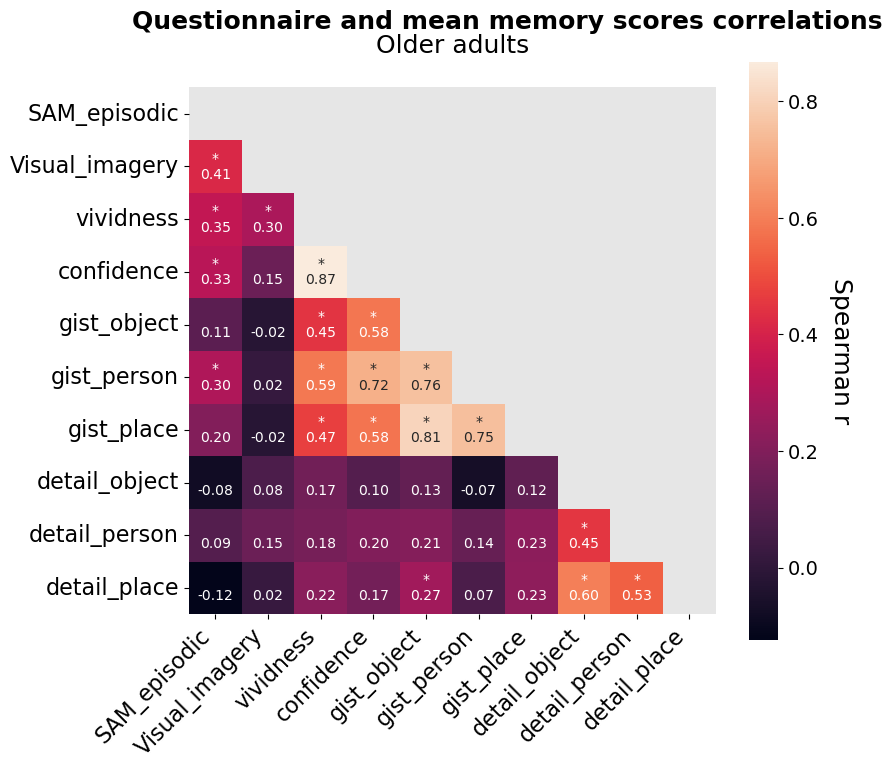

In [54]:
# plot correlations
plot_cor_heatmap(ques_cors_older, l=labels, cmap="rocket", title = 'Older adults', suptitle='Questionnaire and mean memory scores correlations')

# save 
plt.savefig("plots/older_questionnaire_performance_correlations.png", bbox_inches = 'tight')
plt.show()

## Younger

bonferroni-corrected critical r = 0.185


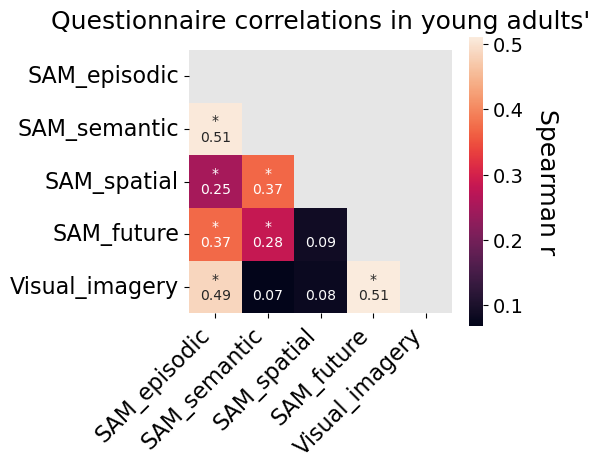

In [55]:
ques_data_younger = younger_ques_df[ques_measures]
ques_cors_younger = ques_data_younger.corr(method='spearman')
np.fill_diagonal(ques_cors_younger.values, np.nan)

# define which correlations are significant based on critical r:
pmask, labels, r_sig = fetch_sig_cors(ques_cors_younger, ques.shape[0])
print('bonferroni-corrected critical r =',np.round(r_sig,3))

# plot correlations
plot_cor_heatmap(ques_cors_younger, l = labels, cmap="rocket", title='Questionnaire correlations in young adults\'')
plt.savefig("./plots/younger_questionnaires_cor.pdf", bbox_inches = 'tight')

In [56]:
ques_data_younger = younger_ques_df[measures]

# calculate correlations
ques_cors_younger = ques_data_younger.corr(method='spearman').loc[measures]
np.fill_diagonal(ques_cors_younger.values, np.nan)

# get significance labels:
pmask, labels, r_sig = fetch_sig_cors(ques_cors_younger, ques.shape[0], sym=False)
print('bonferroni-corrected critical r =',np.round(r_sig,3))
ques_cors_younger

bonferroni-corrected critical r = 0.233


,SAM_episodic,Visual_imagery,vividness,confidence,gist_object,gist_person,gist_place,detail_object,detail_person,detail_place
SAM_episodic,NaN,0.485465,0.253130,0.105777,-0.107955,-0.056130,-0.048426,0.027447,0.025736,-0.041182
Visual_imagery,0.485465,NaN,0.171855,0.076716,-0.177568,-0.048686,-0.157907,-0.021113,0.139613,-0.148478
vividness,0.253130,0.171855,NaN,0.735445,0.424703,0.369756,0.386097,0.272198,0.291467,0.322381
confidence,0.105777,0.076716,0.735445,NaN,0.701638,0.673032,0.700140,0.505587,0.356161,0.433851
gist_object,-0.107955,-0.177568,0.424703,0.701638,NaN,0.782376,0.891701,0.527703,0.358990,0.585604
gist_person,-0.056130,-0.048686,0.369756,0.673032,0.782376,NaN,0.776900,0.432347,0.411743,0.464091
gist_place,-0.048426,-0.157907,0.386097,0.700140,0.891701,0.776900,NaN,0.504995,0.289071,0.556599
detail_object,0.027447,-0.021113,0.272198,0.505587,0.527703,0.432347,0.504995,NaN,0.389582,0.475226
detail_person,0.025736,0.139613,0.291467,0.356161,0.358990,0.411743,0.289071,0.389582,NaN,0.454374
detail_place,-0.041182,-0.148478,0.322381,0.433851,0.585604,0.464091,0.556599,0.475226,0.454374,NaN


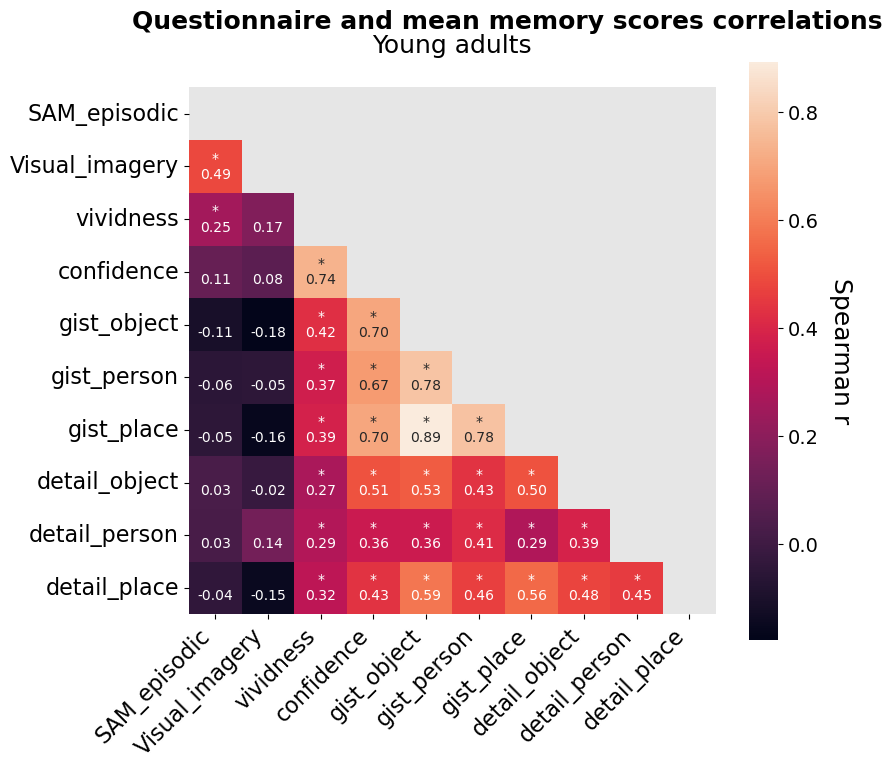

In [57]:
# plot correlations
plot_cor_heatmap(ques_cors_younger, l=labels, cmap="rocket", title = 'Young adults', suptitle='Questionnaire and mean memory scores correlations')

# save 
plt.savefig("plots/younger_questionnaire_performance_correlations.png", bbox_inches = 'tight')
plt.show()